In [0]:
import os

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models

%matplotlib inline 
import matplotlib.pyplot as plt

# Gather Data

In [2]:
# Download three different English translations of Homer's Illiad
# from three different translators. 
url = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
names = ['cowper.txt', 'derby.txt', 'butler.txt']
for name in names:
  text_dir = tf.keras.utils.get_file(name, origin=url+name)

# Note the data directory.
parent_dir = os.path.dirname(text_dir)
print(parent_dir)

811008/807992 [==============================] - 0s 0us/step
/root/.keras/datasets


In [3]:
# See how many samples we have in each file.
! wc -l /root/.keras/datasets/*.txt

  12131 /root/.keras/datasets/butler.txt
  19142 /root/.keras/datasets/cowper.txt
  18333 /root/.keras/datasets/derby.txt
  49606 total


In [4]:
# Check out one of the translations.
! head /root/.keras/datasets/butler.txt

﻿Sing, O goddess, the anger of Achilles son of Peleus, that brought
countless ills upon the Achaeans. Many a brave soul did it send
hurrying down to Hades, and many a hero did it yield a prey to dogs and
vultures, for so were the counsels of Jove fulfilled from the day on
which the son of Atreus, king of men, and great Achilles, first fell
out with one another.
And which of the gods was it that set them on to quarrel? It was the
son of Jove and Leto; for he was angry with the king and sent a
pestilence upon the host to plague the people, because the son of
Atreus had dishonoured Chryses his priest. Now Chryses had come to the


# Pre-process the data

In [0]:
# labeler casts an input index to a new type (tf.int64).
def labeler(example, index):
  return example, tf.cast(index, tf.int64) 

In [0]:
# This time we are going to use a couple convenient text-processing utilities
# built into TensorFlow to pre-process the data. PyTorch has similar utilies 
# in TorchText.

# Create a list that will hold our labeled datasets.
labeled_data_sets = []

# Loop over the translation files and use TextLineDataset to create a dataset 
# in which each sample is a line of text from the input file.
for i, name in enumerate(names):
  lines_dataset = tf.data.TextLineDataset(os.path.join(parent_dir, name))
  labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
  labeled_data_sets.append(labeled_dataset)

In [0]:
# Concatenate all the data together.
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

# Shuffle the data. The 50000 number here is a buffer that TensorFlow fills as
# it shuffles the data. The buffer should be greater than or equal to the full 
# numbers of samples in the dataset.
all_labeled_data = all_labeled_data.shuffle(
    50000, reshuffle_each_iteration=False)

In [8]:
# We can use the take method to print some of the data and see what it
# looks like.
for ex in all_labeled_data.take(5):
  print('Text:', ex[0])
  print('Label:', ex[1])
  print('')

Text: tf.Tensor(b'Our city walls; and my three brothers, sons', shape=(), dtype=string)
Label: tf.Tensor(0, shape=(), dtype=int64)

Text: tf.Tensor(b'_They_ were a multitude in number more', shape=(), dtype=string)
Label: tf.Tensor(0, shape=(), dtype=int64)

Text: tf.Tensor(b'dead on the plain as you did Patroclus."', shape=(), dtype=string)
Label: tf.Tensor(2, shape=(), dtype=int64)

Text: tf.Tensor(b'Appear before them; daunted at the sight,', shape=(), dtype=string)
Label: tf.Tensor(1, shape=(), dtype=int64)

Text: tf.Tensor(b"Prone in the dust he fell, and clutch'd the ground.", shape=(), dtype=string)
Label: tf.Tensor(1, shape=(), dtype=int64)



In [9]:
# Next we need to encode words into index values from a vocabulary, which also
# means that we need to build a vocabulary. First, let's create a tokenizer to 
# split the text into words.
tokenizer = tfds.features.text.Tokenizer()

# Build our vocabulary of words.
vocabulary_set = set()
for text_tensor, _ in all_labeled_data:
  tokens = tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(tokens)

# See the size of our vocab.
vocab_size = len(vocabulary_set)
vocab_size

17178

In [0]:
# Finally let's encode each of our examples into a list of vocabulary index
# values using the vocabulary and the TokenTextEncoder function from TF.
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

# encode_text encodes a text sample with the TokenTextEncoder.
def encode_text(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label

# encode_sample encodes a labeled sample from the data set and outputs a tensor.
def encode_sample(text, label):
  encoded_text, label = tf.py_function(encode_text, inp=[text, label], 
                                       Tout=(tf.int64, tf.int64))
  encoded_text.set_shape([None])
  label.set_shape([])
  return encoded_text, label

# Encode all our data using the above functions.
all_encoded_data = all_labeled_data.map(encode_sample)

In [0]:
# We will keep 5000 samples out for our test set, and we will use a batch size
# of 64 samples during training.
test_size = 5000
batch_size = 64

# Create our training and test batches. Note, we are using a function called
# padded_batch here which takes care of padding the samples due to their varied
# sequence length.
train_data = all_encoded_data.skip(test_size).shuffle(50000)
train_data = train_data.padded_batch(batch_size, padded_shapes=([None],[]))
test_data = all_encoded_data.take(test_size)
test_data = test_data.padded_batch(batch_size, padded_shapes=([None],[]))

# We have padded the dataset with a new token "0" so we need to increase
# the size of our vocab.
vocab_size += 1

# Define the model

In [0]:
# mynet initializes our neural network model
def mynet():

  # This is a Sequential "stack of layers" model.
  model = models.Sequential()

  # Add an embedding layer with a size vocab_size x 64, because we are
  # using a batch size of 64. 
  model.add(tf.keras.layers.Embedding(vocab_size, 64))

  # Add an Bidirectional LSTM layer. Bidirectional means that forward looking
  # and backward looking LSTM cells are both used.
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))

  # Add 2 dense layers, each with 64 nodes.
  for units in [64, 64]:
    model.add(tf.keras.layers.Dense(units, activation='relu'))

  # Create our output layer for our three classes.
  model.add(tf.keras.layers.Dense(3))

  return model

In [0]:
# Intialize the model
model = mynet()

In [0]:
# In this case we are going to update our optimization strategy to "adam," which
# is quite widely used. We are also going to use the SparseCategoricalCrossentropy
# loss which excepts our categories to NOT be one hot encoded and accounts for
# this internally. 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model

In [15]:
# Train (aka fit) the model. 
num_epochs = 3
history = model.fit(train_data, epochs=num_epochs)

Epoch 1/3
697/697 [==============================] - 11s 15ms/step - loss: 0.5359 - accuracy: 0.7409
Epoch 2/3
697/697 [==============================] - 11s 16ms/step - loss: 0.3003 - accuracy: 0.8681
Epoch 3/3
697/697 [==============================] - 11s 16ms/step - loss: 0.2290 - accuracy: 0.9003


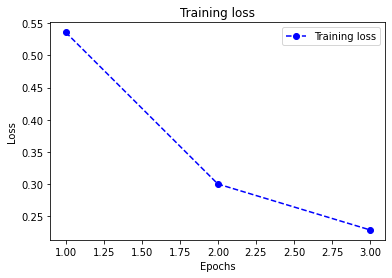

In [16]:
# Plot the training loss for each epoch to see how the model converged.
history_dict = history.history
plt.plot(list(range(1,num_epochs+1)), history_dict['loss'], 'bo--', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Evaluate the model

In [17]:
# Evaluate the model on the test set. 
test_loss, test_acc = model.evaluate(test_data, verbose=2)

print('\nTest accuracy:', test_acc)

79/79 - 2s - loss: 0.3906 - accuracy: 0.8258

Test accuracy: 0.8258000016212463
